In [1]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.8 MB/s eta 0:00:00


In [54]:
import csv
from scapy.all import rdpcap
import pandas as pd
from datetime import datetime

def analyze_pcap(file_pcap, output_csv):
    packets = rdpcap(file_pcap)

    # Dizionario per tenere traccia dei conteggi
    packet_counts = {}

    # Definizione degli indirizzi IP dei server
    service_ips = {
        '10.0.0.3': 1,
        '10.0.0.4': 2,
        '10.0.0.5': 3
    }

    # Analisi pacchetti
    for pkt in packets:

        if pkt.haslayer('ARP'):
            continue
        timestamp = int(pkt.time)
        actual_time = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

        # Inizio conteggio dei pacchetti
        if actual_time not in packet_counts:
            packet_counts[actual_time] = {'total': 0, 'services': set()}

        packet_counts[actual_time]['total'] += 1

        # Determina il tipo di servizio
        service_type = 0
        if pkt.haslayer('IP'):
            if pkt['IP'].dst in service_ips:
                service_type = service_ips[pkt['IP'].dst]
            elif pkt['IP'].src in service_ips:
                service_type = service_ips[pkt['IP'].src]

        if service_type != 0:
            packet_counts[actual_time]['services'].add(service_type)

    data = []
    for time, counts in sorted(packet_counts.items()):
        for service_type in counts['services']:
            data.append([time, counts['total'], service_type])

    # Creazione del file CSV
    df = pd.DataFrame(data, columns=["Time", "TotalPackets", "ServiceType"])
    df.to_csv(output_csv, index=False)

    print(f"File CSV generato: {output_csv}")


#TrainingSet.pcap per trainare e s2_eth1.pcap per validation
input_pcap = "training.pcap"
output_csv = "Training.csv"
analyze_pcap(input_pcap, output_csv)
input_pcap= "validation.pcap"
output_csv = "Validation.csv"
analyze_pcap(input_pcap, output_csv)


File CSV generato: Validation_prova.csv


In [55]:
import pandas as pd

# Carica il dataset
def normalize_csv(file_csv, output_csv):
  normalize_data = pd.read_csv(file_csv)

  # Conversione di 'Time'
  normalize_data['Time'] = pd.to_datetime(normalize_data['Time'], errors='coerce')

  normalize_data['Time'] = normalize_data['Time'].apply(lambda x: x.timestamp() if pd.notna(x) else 0.0)
  min_time = normalize_data['Time'].min()

  # Normalizzazione utilizzando il valore minore del dataset
  normalize_data['Time'] = normalize_data['Time'] - min_time

  # Salvataggio in file csv
  normalize_data.to_csv(output_csv, index=False)
  print(f"File salvato come {output_csv}")

input_csv = "Training.csv"
output_csv = "Training_normalized.csv"
normalize_csv(input_csv, output_csv)
input_csv = "Validation.csv"
output_csv = "Validation_normalized.csv"
normalize_csv(input_csv, output_csv)

File salvato come Validation_normalized_prova.csv


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
import numpy as np
import joblib

def train_and_pred(input_csv, future_time, future_service_type):
  data = pd.read_csv(input_csv)

  # Split delle feature per training
  X = data[['Time', 'ServiceType']].values
  y = data['TotalPackets'].values

 # Split del dataset in training e test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Definizione trasformatore polinomiale
  poly = PolynomialFeatures(degree=2)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.transform(X_test)

  # Definizione e addestramento del modello
  model = LinearRegression()
  model.fit(X_train_poly, y_train)

  # Predizione su test set
  y_pred = model.predict(X_test_poly)

  # Valutazione del modello
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")

  # Esempio di previsione per un timestamp e un tipo di servizio specifico
  future_features = np.array([[future_time, future_service_type]])
  future_features_poly = poly.transform(future_features)
  predicted_packets = model.predict(future_features_poly)
  print(f"Previsione del numero di pacchetti per il tempo e il tipo di servizio specificato: {predicted_packets[0]}")

  # Salvataggio del modello e del trasformatore
  joblib.dump(model, 'regression_model.pkl')
  joblib.dump(poly, 'polynomial_transformer.pkl')
  print("Modello e trasformatore salvati con successo.")

input_csv= "Training_normalized.csv"
future_time = "763.0"
future_service_type = 2
train_and_pred(input_csv, future_time, future_service_type)


Mean Squared Error: 2865.555488247493
Previsione del numero di pacchetti per il tempo e il tipo di servizio specificato: 7.174164869260949
Modello e trasformatore salvati con successo.


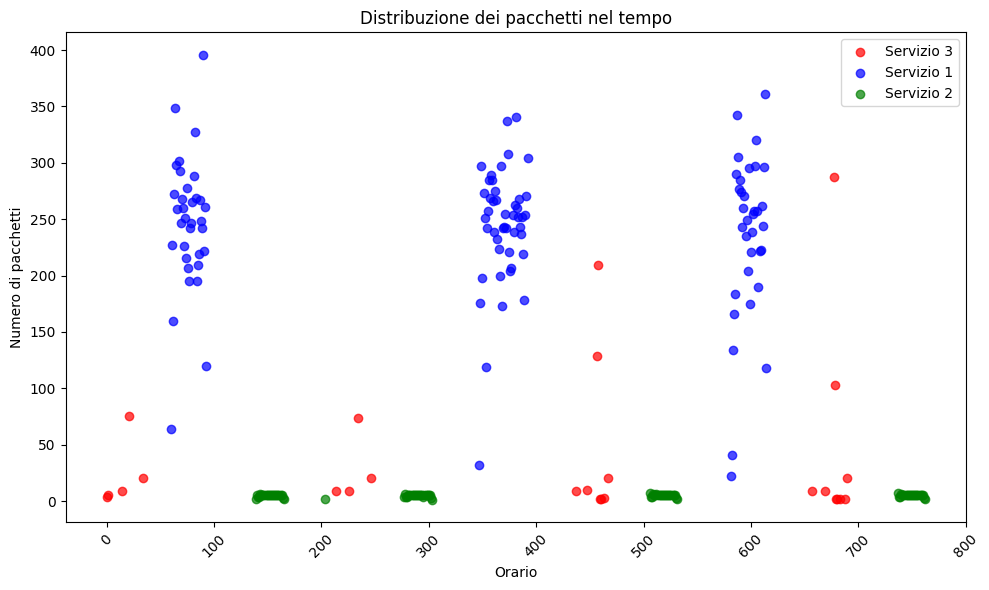

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


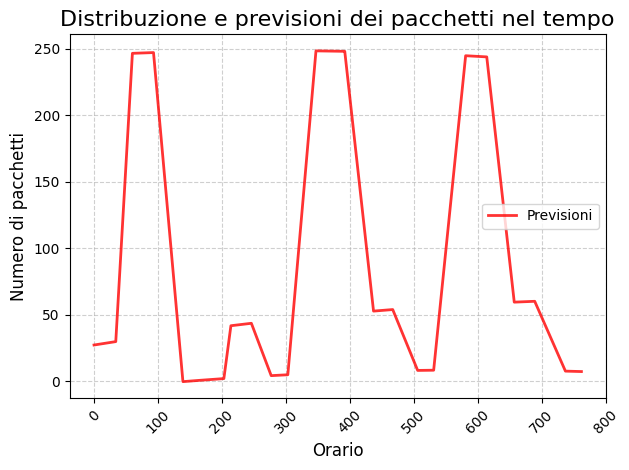

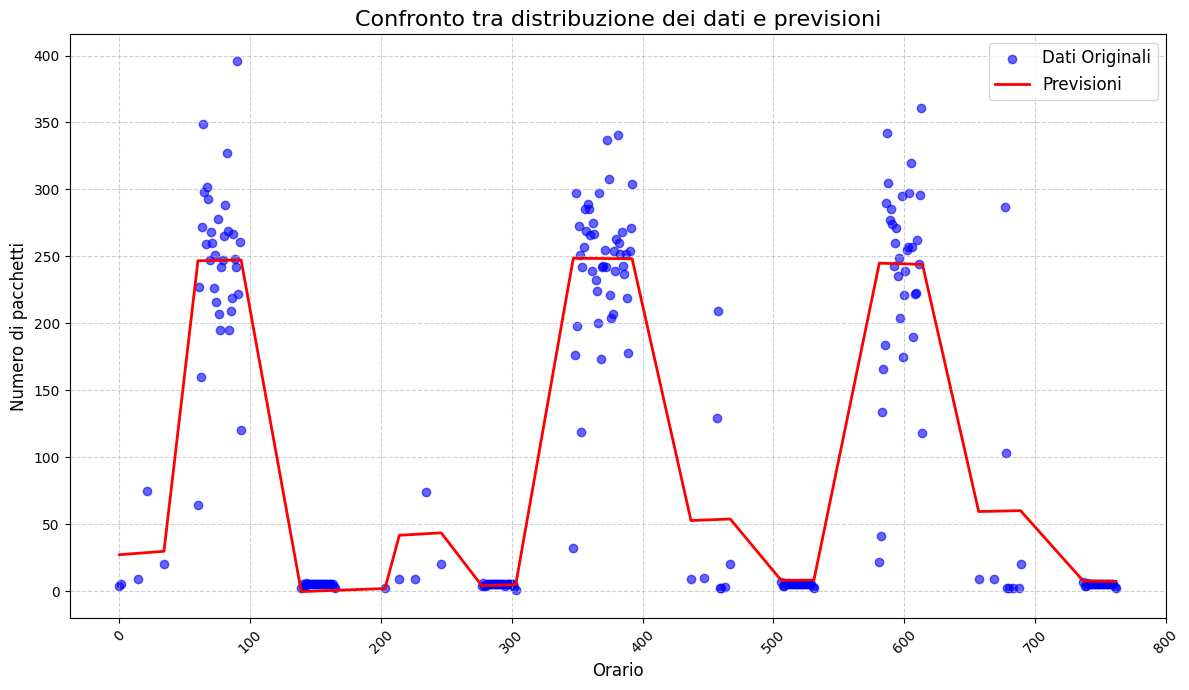

In [52]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

def plot_prediction(input_csv, poly, model):
  # Carica i dati dal file CSV
  data = pd.read_csv(input_csv)
  # Definizione colori per servizio
  service_color_map = {1: 'blue', 2: 'green', 3: 'red'}
  data['Color'] = data['ServiceType'].map(service_color_map)

  # Grafico della distribuzione dei dati
  plt.figure(figsize=(10, 6))

  # Scatter plot
  for service_type in data['ServiceType'].unique():
      subset = data[data['ServiceType'] == service_type]
      plt.scatter(subset['Time'], subset['TotalPackets'],
                  color=service_color_map[service_type],
                  label=f"Servizio {service_type}", alpha=0.7)

  plt.xlabel("Orario")
  plt.ylabel("Numero di pacchetti")
  plt.title("Distribuzione dei pacchetti nel tempo")
  plt.legend()
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  X_poly = poly.transform(data[["Time", "ServiceType"]])
  y_pred_all = model.predict(X_poly)

  # Grafico
  plt.plot(data["Time"], y_pred_all, color="red", label="Previsioni", linewidth=2, alpha=0.8)
  plt.xlabel("Orario", fontsize=12)
  plt.ylabel("Numero di pacchetti", fontsize=12)
  plt.title("Distribuzione e previsioni dei pacchetti nel tempo", fontsize=16)
  plt.legend()
  plt.xticks(rotation=45)
  plt.grid(True, linestyle="--", alpha=0.6)
  plt.tight_layout()
  plt.show()

  data["Predicted"] = y_pred_all


  plt.figure(figsize=(12, 7))

  plt.scatter(data["Time"], data["TotalPackets"], color="blue", label="Dati Originali", alpha=0.6)
  plt.plot(data["Time"], data["Predicted"], color="red", label="Previsioni", linewidth=2)

  plt.title("Confronto tra distribuzione dei dati e previsioni", fontsize=16)
  plt.xlabel("Orario", fontsize=12)
  plt.ylabel("Numero di pacchetti", fontsize=12)
  plt.legend(fontsize=12)
  plt.grid(True, linestyle="--", alpha=0.6)
  plt.xticks(rotation=45)
  plt.tight_layout()

input_csv= "Training_normalized.csv"
poly = joblib.load("polynomial_transformer.pkl")
model = joblib.load("regression_model.pkl")
plot_prediction(input_csv, poly, model)

Mean Squared Error sul dataset di validazione: 1864.6661767846826


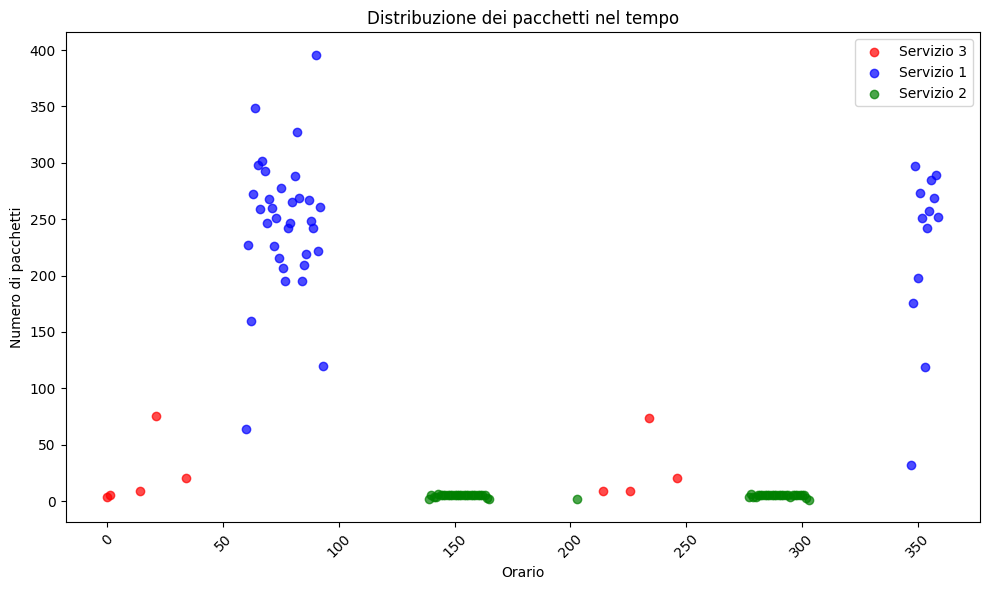

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


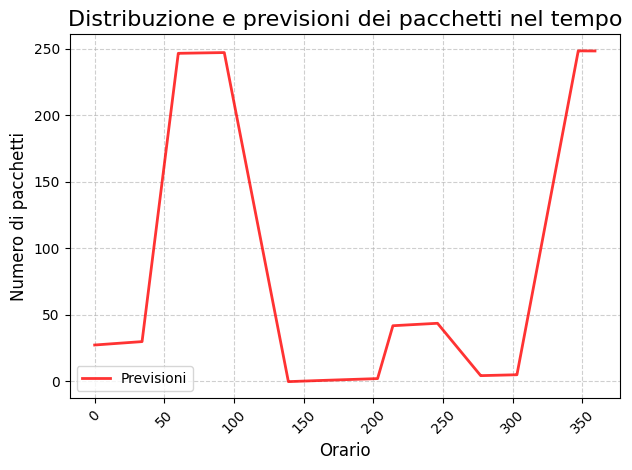

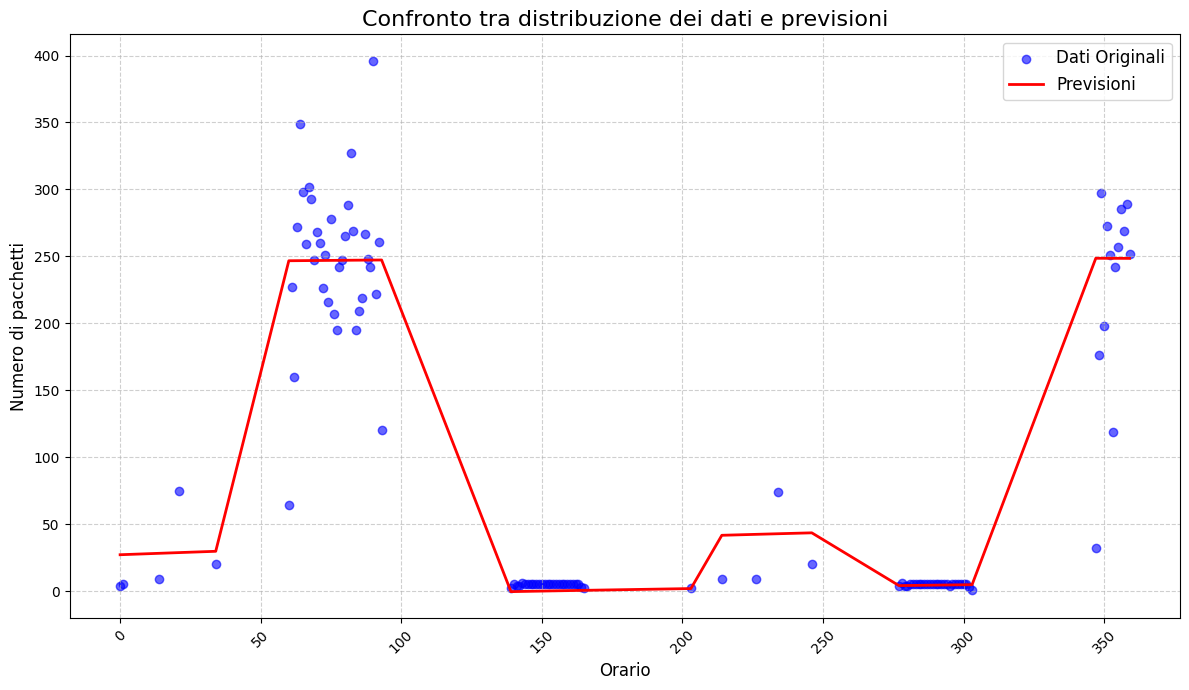

In [60]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from sklearn.metrics import mean_squared_error

def validation(input_csv, model, poly):
    # Lettura del dataset
    validation_data = pd.read_csv(input_csv)
    # Preprocessamento dati con poly
    X_validation = validation_data[['Time', 'ServiceType']].values
    X_validation_poly = poly.transform(X_validation)
    # Predizione
    y_pred_validation = model.predict(X_validation_poly)
    y_validation = validation_data['TotalPackets'].values
    # Calcolo mse
    mse_validation = mean_squared_error(y_validation, y_pred_validation)

    print(f"Mean Squared Error sul dataset di validazione: {mse_validation}")

input_csv= "Validation_normalized.csv"
model = joblib.load('regression_model.pkl')
poly = joblib.load('polynomial_transformer.pkl')
validation(input_csv, model, poly)
plot_prediction(input_csv, poly, model)
